suggestion for using TF Object Detection
https://medium.com/@anthony_sarkis/self-driving-cars-implementing-real-time-traffic-light-detection-and-classification-in-2017-7d9ae8df1c58

Google's Approach to traffic light
https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/37259.pdf

SqueezeNet trained on ImageNet
https://medium.freecodecamp.org/recognizing-traffic-lights-with-deep-learning-23dae23287cc

Convert Caffe Models to TF
https://github.com/ethereon/caffe-tensorflow

Transfer Learning using Keras (blog)
https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8



### Imports

In [127]:
# So we can see the output of multiple variables in a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from tqdm import tqdm

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

from sklearn.utils import shuffle

# Download Datasets
 
Change the download_dir in config.py

---
## Los Altos
Contains a png images of real driving in Los Altos and the classification of and bounding box of traffic lights

##### data
./data/los-altos/train/\*\*/\*.png
##### labels
./data/los-altos/train.yaml
Labels are in yaml format
```yaml
  path: ./rgb/train/2015-10-05-16-02-30_bag/703062.png
- boxes:
  - {label: RedLeft, occluded: false, x_max: 536.2627074943, x_min: 527.9504961004,
    y_max: 259.4134134066, y_min: 239.7337501584}
  - {label: Red, occluded: false, x_max: 606.5768706269, x_min: 599.1649383548, y_max: 258.8548785478,
    y_min: 239.7216236998}
  - {label: Red, occluded: false, x_max: 663.2255031115, x_min: 655.7908822815, y_max: 258.9849821711,
    y_min: 240.196122899}
  - {label: Red, occluded: false, x_max: 832.5396369015, x_min: 820.5931243983, y_max: 277.8766194893,
    y_min: 245.8794585057}
  path: ./rgb/train/2015-10-05-16-02-30_bag/703270.png
```
---
## Just Traffic Lights
Only contains cropped images of Traffic Lights (png)
##### data
./data/just-traffic-lights / [ real | simulated ] / [ Green|NoTraficLight|Red|Yellow ] /\*.png

In [2]:
import config
import download

for dataset in config.datasets:
    download.maybe_download_and_extract(dataset, config.download_dir)

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


In [3]:
# explore data
import os
from glob import glob
os.listdir('./data')

['.DS_Store',
 'los-altos',
 'dataset_additional_rgb.zip',
 'dataset_train_rgb_bosch.zip',
 'just-traffic-lights',
 'los-altos.zip',
 'tmp',
 'tl_classifier_data.zip']

In [4]:
image_paths = []
for root, dirs, files in os.walk('./data/just-traffic-lights'):
    for file in files:
        image_paths.append(os.path.join(root,file))

In [5]:
from collections import namedtuple

Image_Size = namedtuple('Image_Size', 'x y ch')
image_size = Image_Size(x=50, y=50, ch=3)
num_classes = 4

In [151]:
# create validation train and test set
image_paths = shuffle(image_paths)

train_image_paths = image_paths[:-100]
test_image_paths = image_paths[-100:]
len(train_image_paths)
len(test_image_paths)
x = [i.split('/')[-2] for i in train_image_paths]
len([i for i in x if i == "Green"])
len([i for i in x if i == "Yellow"])
len([i for i in x if i == "Red"])
len([i for i in x if i == "NoTrafficLight"])

972

100

334

64

551

23

In [158]:
def create_indices(image_paths):
    """
    0 = none
    1 = green
    2 = yellow
    3 = red
    
    :return :
    {'./data/just-traffic-lights/real/Green/001094.png': 1}
    """

    ind_dict = {}
    for img in image_paths:
        if "NoTrafficLight" in img: 
            ind_dict[img] = 0
        if "Green" in img: 
            ind_dict[img] = 1
        if "Yellow" in img: 
            ind_dict[img] = 2
        if "Red" in img: 
            ind_dict[img] = 3
        if not ind_dict[img]:
            print(img)
            
    return ind_dict

def get_one_hot(image_paths, ver='keras'):
    
    ind = create_indices(image_paths)
    ind = [ind for key,ind in ind.items()]
    
    # tf version
    if ver=='tf':
        one_hot = tf.one_hot(ind, num_classes)
    
    # keras version
    if ver=="keras":
        one_hot = keras.utils.to_categorical(ind, num_classes=num_classes)
    
    return one_hot

get_one_hot(image_paths[:5])

./data/just-traffic-lights/real/NoTrafficLight/001053.png


array([[ 0.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.]])

In [155]:
import tensorflow as tf
from scipy.ndimage import imread
from skimage.transform import resize

In [175]:
a = np.ones((4, 3, 2))
a
a.shape

# npad is a tuple of (n_before, n_after) for each dimension
npad = ((0, 0), (1, 2), (2, 1))
b = np.pad(a, pad_width=npad, mode='constant', constant_values=0)

print(b.shape)
# (4, 6, 5)

print(b)

array([[[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.],
        [ 1.,  1.]]])

(4, 3, 2)

(4, 6, 5)
[[[ 0.  0.  0.  0.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  1.  1.  0.]
  [ 0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.]]]


In [171]:
def generator(samples, batch_size=1, verbose=False):
    shuffle(samples)
    num_samples = len(samples)
    
    for offset in range(0, num_samples, batch_size):
        
        # get a batch of image_paths
        x_batch_paths = samples[offset : offset+batch_size]
        x_batch = []
        for img_path in x_batch_paths:
            img = imread(img_path)
            new_shape = resize(img, (50, 50)) 
            x_batch.append(new_shape)
            
        # reshape images to 4D: (batch_size, row, col, chs)
        x_batch = np.array(x_batch)
        if verbose: print('++', x_batch.size)
        x_batch = x_batch.reshape(batch_size, 150, 150, image_size.ch)
        
        # get one-hot-encode labels based on path name
        y_batch = get_one_hot(x_batch_paths)

        if not len(y_batch) == len(x_batch):
            print('Wrong Match ', len(y_batch), len(x_batch))
        yield (x_batch, y_batch)
            
train_generator = generator(image_paths, 972, verbose=False)

x,y = next(train_generator)
x.shape
y.shape

/Users/topher/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


ValueError: cannot reshape array of size 7290000 into shape (972,150,150,3)

In [161]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    fill_mode = "nearest",
    shear_range = 0.5,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rotation_range=10)

In [162]:
valid_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = False,
fill_mode = "nearest",
zoom_range = 0.0,
width_shift_range = 0.0,
height_shift_range=0.0,
rotation_range=0)

In [163]:
x_train, y_train = next(generator(train_image_paths, batch_size=972))
x_test, y_test = next(generator(test_image_paths, batch_size=100))

train_gen = train_datagen.flow(x=x_train, y=y_train)
test_gen = train_datagen.flow(x=x_test, y=y_test)

x_train.shape

/Users/topher/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


./data/just-traffic-lights/real/NoTrafficLight/001053.png
./data/just-traffic-lights/simulator/NoTrafficLight/001111.png
./data/just-traffic-lights/real/NoTrafficLight/001060.png
./data/just-traffic-lights/real/NoTrafficLight/000066.png
./data/just-traffic-lights/real/NoTrafficLight/001216.png
./data/just-traffic-lights/real/NoTrafficLight/001223.png
./data/just-traffic-lights/real/NoTrafficLight/000088.png
./data/just-traffic-lights/simulator/NoTrafficLight/001108.png
./data/just-traffic-lights/real/NoTrafficLight/001464.png
./data/just-traffic-lights/real/NoTrafficLight/000083.png
./data/just-traffic-lights/real/NoTrafficLight/001342.png
./data/just-traffic-lights/real/NoTrafficLight/001327.png
./data/just-traffic-lights/simulator/NoTrafficLight/001103.png
./data/just-traffic-lights/real/NoTrafficLight/001466.png
./data/just-traffic-lights/simulator/NoTrafficLight/001119.png
./data/just-traffic-lights/real/NoTrafficLight/001070.png
./data/just-traffic-lights/real/NoTrafficLight/00107

(972, 150, 150, 3)

In [122]:
model = Sequential()
model.add(Resize())
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(150, 150, 3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 146, 146, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 73, 73, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 73, 73, 64)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 341056)            0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               43655296  
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
__________

In [174]:
# samples_per_epoch = len(images_paths)
nb_val_samples = 10
nb_max_epoch = 10
steps_per_epoch = 128

hist = model.fit_generator(
    generator=train_gen, 
    steps_per_epoch=steps_per_epoch,
    epochs=nb_max_epoch,
    validation_data=test_gen,
    use_multiprocessing=True)
    

Epoch 1/10
64/64 [==============================] - 163s 3s/step - loss: 0.3051 - acc: 0.8952 - val_loss: 0.2625 - val_acc: 0.9000
Epoch 2/10
64/64 [==============================] - 162s 3s/step - loss: 0.2555 - acc: 0.9136 - val_loss: 0.2176 - val_acc: 0.9100
Epoch 3/10
64/64 [==============================] - 163s 3s/step - loss: 0.2430 - acc: 0.9184 - val_loss: 0.2083 - val_acc: 0.9200
Epoch 4/10
64/64 [==============================] - 161s 3s/step - loss: 0.1967 - acc: 0.9318 - val_loss: 0.2119 - val_acc: 0.9200
Epoch 5/10
64/64 [==============================] - 170s 3s/step - loss: 0.1771 - acc: 0.9396 - val_loss: 0.2121 - val_acc: 0.9300
Epoch 6/10
64/64 [==============================] - 168s 3s/step - loss: 0.1768 - acc: 0.9431 - val_loss: 0.1834 - val_acc: 0.9300
Epoch 7/10
64/64 [==============================] - 162s 3s/step - loss: 0.1437 - acc: 0.9533 - val_loss: 0.1831 - val_acc: 0.9400
Epoch 8/10
64/64 [==============================] - 159s 2s/step - loss: 0.1454 - a

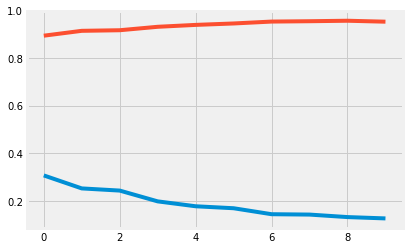

In [176]:
acc = hist.history['acc']
loss = hist.history['loss']
plt.plot(loss)
plt.plot(acc)
plt.show();